In [6]:
import requests
import json
import datetime

today = datetime.date.today()
year = today.year
year_prev = year - 1

# Variables for in the url
latitude = 52.01
longitude = 4.36
start_date = f"{year_prev}-01-01"
end_date = f"{year_prev}-12-31"

# API Get max historical temperatures
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max&timezone=Europe%2FBerlin"

# Send the API request and get the response
response = requests.get(url)
response = response.text
# print(url) # for checking in browser

# Make a dictionary out of the response and extract necessary portion
dict_response = json.loads(response)
lst = dict_response['daily']['temperature_2m_max']

# remove empty data entries & get highest temperature measured
lst = [x for x in lst if x is not None]
highest_temp = max(lst)

# API Get Humidity data (this is only available in hourly data instead of daily hence different api request)
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly=relativehumidity_2m&timezone=Europe%2FBerlin"

# Send the API request and get the response
response = requests.get(url)
response = response.text

# Make a dictionary out of the response and extract necessary portion
dict_response = json.loads(response)
lst = dict_response['hourly']['relativehumidity_2m']

# remove empty data entries & get average humidity measured
lst = [x for x in lst if x is not None]
average_humidity = sum(lst) / len(lst)


# https://www.knmi.nl/nederland-nu/KNMI14_klimaatscenarios/kerncijfers
HumidityPredictionKNMI = average_humidity - 2.5
TempPredicitonKNMI = highest_temp + 2.3

# improvement point: get highest humidity level of the max temperature date instead of average of all year

In [20]:
import math
import matplotlib.pyplot as plt
import numpy as np

material = "concrete"
TKelvinOld = highest_temp + 273.15
TKelvinNew = TempPredicitonKNMI + 273.15
RHumOld = average_humidity
RHumNew = HumidityPredictionKNMI
kg = 10

match material:
    case "concrete":
        # https://www.mdpi.com/2075-5309/13/4/965
        # Lu Z-H, Lun P-Y, Li W, Luo Z, Li Y, Liu P. Empirical model of corrosion rate for steel reinforced concrete structures in chloride-laden environments. Advances in Structural Engineering. 2019;22(1):223-239. doi:10.1177/1369433218783313 https://journals.sagepub.com/doi/full/10.1177/1369433218783313

        print('owo')
        time = 1 # years
        wc = 0.45 # water cement ratio
        C = 50 # concrete cover thickness mm
        Ct = 0.20  # chloride content by weight of concrete (kg/m3)
        Rho = 1 # concrete resistivity (kΩ cm)
        
        #time = np.array([0, 10, 30, 50, 80, 100, 150])
        # ADD TIME
        # ADD ACTUAL MASS LOSS (CONVERT WITH MOLLES)


        lognew = (math.log(Ct - (3034 / (TKelvinNew * (2.5 + RHumNew) - (5*(10**-3) * Rho)))))
        corrosionratetimewisenew = 1.38 * (((1 - wc)**-1.64) / (((1 + time) * C)**(1/3))) * math.exp(1.23 + 0.618 * lognew)
        # (μA/cm2)

        logold = (math.log(Ct - (3034 / (TKelvinOld * (2.5 + RHumOld) - (5*(10**-3) * Rho)))))
        corrosionratetimewisenewold = 1.38 * (((1 - wc)**-1.64) / (((1 + time) * C)**(1/3))) * math.exp(1.23 + 0.618 * logold)

        #corrosionratetimewise = 1.38 * ((1 - wc)**-1.64) / (((1 + time) * C)**1/3) * math.exp(1.23 + 0.618 * math.log(Ct-(3034 / (TemperatureNew * (2.5 + RHum)- ((5*(10**-3)) * Rho)))))
        print(corrosionratetimewisenew, corrosionratetimewisenewold)


    case "wood":
        # validation of method https://www.fpl.fs.usda.gov/documnts/pdf2001/white01a.pdf
        # https://www.e3s-conferences.org/articles/e3sconf/pdf/2021/56/e3sconf_icsf2021_07009.pdf
        # A = 10000000000000 # preexponential factor, constant for small temperature changes such as 10 C https://www.chemguide.co.uk/physical/basicrates/arrhenius.html
        R = 8.31446261815324 # Universal gas Constant J K-1 mol-1
        #EActEnergy = 132.49 * 1000 # https://www.sciencedirect.com/science/article/abs/pii/S096085241931329X
        EActEnergy = 130 * 1000 # file:///D:/Downloads/Kinetic_analysis_of_thermal_degradation_of_Cedrela.pdf
        A = 1.57* (10**12) # 1.57* (10**12) # https://www.researchgate.net/publication/299646285_Modeling_of_the_pyrolysis_of_biomass_under_parabolic_and_exponential_temperature_increases_using_the_Distributed_Activation_Energy_Model
        MassLossOld =  A * math.exp(-EActEnergy / (R * TKelvinOld)) # first-order Arrhenius equation, massloss/rateconstant mol^-1 s^-1
        MassLossNew =  A * math.exp(-EActEnergy / (R * TKelvinNew)) # first-order Arrhenius equation, massloss/rateconstant mol^-1 s^-1

        molarmass = 220.2339 # gram/mole C6H12O6 + Ca https://www.plantchicago.org/post/thinking-circular-with-chemistry#:~:text=In%20actuality%20wood%20is%20mostly,formula%20is%3A%20C6H12O6%20%2B%20Ca.

        gram = kg * 1000
        mol = gram / molarmass
        print(mol)

        # total time needed for reduction mass to 0
        totaltimeold = mol / MassLossOld
        totaltime = mol / MassLossNew

        # convertion from mol to kg
        weight = (mol * molarmass) / 1000 # in kg
        lossold = (MassLossOld * molarmass) / 1000
        lossnew = (MassLossNew * molarmass) / 1000
        print(MassLossNew, "masslossnew")

        # seconds and years
        time = np.array([0, 10, 30, 50, 80, 100, 150])
        time_seconds = time.astype(np.int64) * 3600 * 24 * 365
        time_years = time_seconds / (3600 * 24 * 365) # convert time to years

        # forumlas for plotting
        formulanew = (weight - ((lossnew) * (time_seconds.astype(np.int64))))
        formulaold = (weight - ((lossold) * (time_seconds.astype(np.int64))))
        print(time_seconds)
        print(lossnew)
        print(formulanew)

        x_max = np.max(time_seconds)
        y_max = (np.max(formulanew) + (np.max(formulanew)*0.1))
        y_min = np.max(formulanew)*0.9

        fig, ax = plt.subplots()
        ax.plot(time_years, formulanew, label='New')
        ax.plot(time_years, formulaold, label='Old')
        ax.set_title("Degradation")
        ax.set_ylabel('Weight (kg)')
        ax.set_xlabel('Time (years)')
        # ax.set_ylim(y_min, y_max)  # Set x-axis limit from 0
        # ax.set_xticks(time_years)  # Set x-axis ticks to the exact values of time_years
        ax.legend()
        plt.show()


# concrete pdf https://inis.iaea.org/collection/NCLCollectionStore/_Public/28/057/28057515.pdf

owo
0.5390419996579041 0.5528789691241749


In [57]:
TemperatureNew = 30 + 273 # K
time = 1 # years
wc = 0.45 # water cement ratio
C = 50 # concrete cover thickness mm
Ct = 0.20  # chloride content by weight of concrete (kg/m3)
RHumNew = 90 # Relative humidity
Rho = 1 # concrete resistivity (kΩ cm)

#time = np.array([0, 10, 30, 50, 80, 100, 150])
# ADD TIME
# ADD ACTUAL MASS LOSS (CONVERT WITH MOLLES)


RHumOld = 70

lognew = (math.log(Ct - (3034 / (TKelvinNew * (2.5 + RHumNew) - (5*(10**-3) * Rho)))))
corrosionratetimewisenew = (1.38 * (((1 - wc)**-1.64) / (((1 + time) * C)**(1/3)))) * math.exp(1.23 + 0.618 * lognew)
# (μA/cm2)

print(corrosionratetimewisenew)

# Define constants
density = 7.874  # g/cm3 https://amesweb.info/Materials/Density_of_Iron.aspx
atomic_weight_iron = 55.845  # g/mol atomic weight https://ciaaw.org/iron.htm
faraday_constant = 96.485  # C/mol proportionality constant https://www.sciencedirect.com/topics/engineering/faradays-constant#:~:text=The%20known%20Faraday%20constant%2096%2C485,by%201%20mol%20of%20electrons.

# Define input parameters
corrosion_rate = corrosionratetimewisenew   # μA/cm2 in a year

# Coulombs/cm2 (1 microampere is 10**-6 coulombs)
coulombscm2 = corrosion_rate * 10**-6

# https://en.wikipedia.org/wiki/Faraday%27s_laws_of_electrolysis
# m = (Q * M) / (n * Z = Z) formula for Faraday's first law
# mass loss rate in g/cm2/year using Faraday's Law
mass_loss_rate = (coulombscm2 * atomic_weight_iron) / (2 * faraday_constant) # 2 for n is used because 2 electrons are transferred in the electrochemical reaction during oxidation of Fe

# Convert mass loss rate from g/cm2/year to mm/year using density of iron
mm_per_year = (mass_loss_rate * 10**7) / density

# Print result
print(f"The corrosion rate of {corrosion_rate} μA/cm2 in a year corresponds to {mm_per_year:.5f} per year.")

0.619789974498252
The corrosion rate of 0.619789974498252 μA/cm2 in a year corresponds to 0.22779 mm in 1 year.


In [64]:
time = [1, 10, 20, 30]

TKelvinNew = 30 + 273 # K
time = 1 # years
wc = 0.45 # water cement ratio
C = 50 # concrete cover thickness mm
Ct = 0.20  # chloride content by weight of concrete (kg/m3)
RHumNew = 90 # Relative humidity
Rho = 1 # concrete resistivity (kΩ cm)

lognew = (math.log(Ct - (3034 / (TKelvinNew * (2.5 + RHumNew) - (5*(10**-3) * Rho)))))
corrosionratetimewisenew = (1.38 * (((1 - wc)**-1.64) / (((1 + time) * C)**(1/3)))) * math.exp(1.23 + 0.618 * lognew)

ax.plot(time, lognew, label='New')
plt.show()

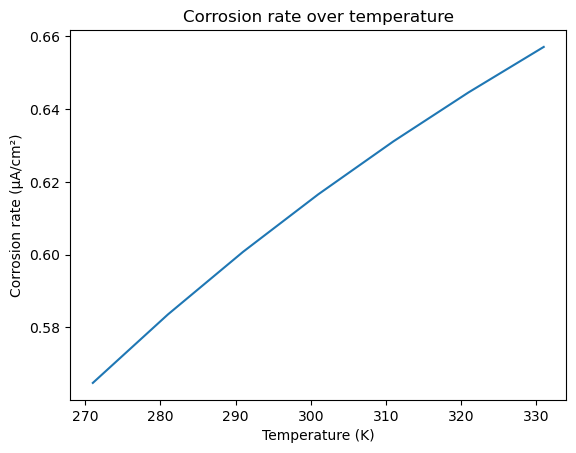

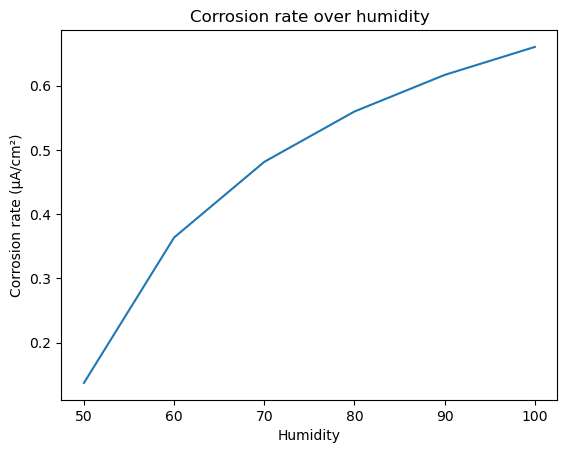

In [12]:
import math
import matplotlib.pyplot as plt

# Input data
Temp = [271, 281, 291, 301, 311, 321, 331]
wc = 0.45 # water cement ratio
C = 50 # concrete cover thickness mm
Ct = 0.20  # chloride content by weight of concrete (kg/m3)
RHumNew = 90 # Relative humidity
Rho = 1 # concrete resistivity (kΩ cm)
t = 1 # time in year

corrosion_rate = [] # Initialize the list

for Te in Temp:
    lognew = (math.log(Ct - (3034 / (Te * (2.5 + RHumNew) - (5*(10**-3) * Rho)))))
    corrosionratetimewisenew = (1.38 * (((1 - wc)**-1.64) / (((1 + t) * C)**(1/3)))) * math.exp(1.23 + 0.618 * lognew)
    corrosion_rate.append(corrosionratetimewisenew)

# Plot the corrosion rate over temperature
plt.plot(Temp, corrosion_rate)
plt.xlabel('Temperature (K)')
plt.ylabel('Corrosion rate (μA/cm²)')
plt.title('Corrosion rate over temperature')
plt.show()



# Input data
Humidity = [50, 60, 70, 80, 90, 100]
Temp = 301 # 30 C
wc = 0.45 # water cement ratio
C = 50 # concrete cover thickness mm
Ct = 0.20  # chloride content by weight of concrete (kg/m3)
RHumNew = 90 # Relative humidity
Rho = 1 # concrete resistivity (kΩ cm)
t = 1 # time in year

corrosion_rate = [] # Initialize the list

# Calculate corrosion rate for each humidity value
for h in Humidity:
    lognew = (math.log(Ct - (3034 / (Temp * (2.5 + h) - (5*(10**-3) * Rho)))))
    corrosionratetimewisenew = (1.38 * (((1 - wc)**-1.64) / (((1 + t) * C)**(1/3)))) * math.exp(1.23 + 0.618 * lognew)
    corrosion_rate.append(corrosionratetimewisenew)

# Plot the corrosion rate against humidity
plt.plot(Humidity, corrosion_rate)
plt.xlabel('Humidity')
plt.ylabel('Corrosion rate (μA/cm²)')
plt.title('Corrosion rate over humidity')
plt.show()

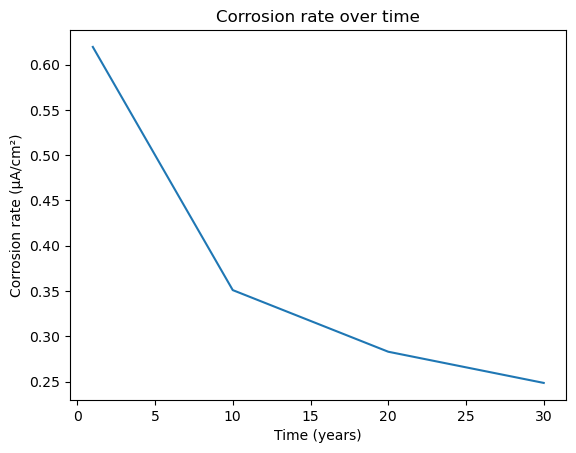

In [65]:
import math
import matplotlib.pyplot as plt

# Input data
time = [1, 10, 20, 30]
TKelvinNew = 30 + 273 # K
wc = 0.45 # water cement ratio
C = 50 # concrete cover thickness mm
Ct = 0.20  # chloride content by weight of concrete (kg/m3)
RHumNew = 90 # Relative humidity
Rho = 1 # concrete resistivity (kΩ cm)

# Calculate the corrosion rate over time
corrosion_rate = []
for t in time:
    lognew = (math.log(Ct - (3034 / (TKelvinNew * (2.5 + RHumNew) - (5*(10**-3) * Rho)))))
    corrosionratetimewisenew = (1.38 * (((1 - wc)**-1.64) / (((1 + t) * C)**(1/3)))) * math.exp(1.23 + 0.618 * lognew)
    corrosion_rate.append(corrosionratetimewisenew)

# Plot the corrosion rate over time
plt.plot(time, corrosion_rate)
plt.xlabel('Time (years)')
plt.ylabel('Corrosion rate (μA/cm²)')
plt.title('Corrosion rate over time')
plt.show()

# https://www.researchgate.net/figure/Corrosion-rate-vs-time-points-experimental-data-lines-model-predictions-conditions_fig8_273460562#:~:text=Corrosion%20rate%20increases%20with%20a,a%20denser%20iron%20sulfide%20layer.
# "Corrosion rate increases with a decrease in pH as expected, since the corrosivity of the solution increases and the solubility of iron increases as well. The decrease of corrosion rate with time is much faster at pH 6.0 due to the formation of a denser iron sulfide layer. "

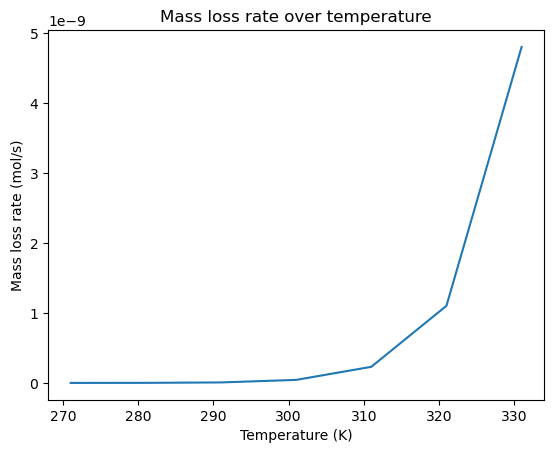

In [19]:
import math
import matplotlib.pyplot as plt

# Input data
Temp = [271, 281, 291, 301, 311, 321, 331]
R = 8.31446261815324 # Universal gas Constant J K-1 mol-1
EActEnergy = 130 * 1000 # Activation energy for the reaction in J/mol
A = 1.57 * (10**12) # Pre-exponential factor in s^-1, obtained from a research paper

# Calculate the mass loss rate using the Arrhenius equation
MassLossformula = []
for T in Temp:
    mass_loss_rate = A * math.exp(-EActEnergy / (R * T))
    MassLossformula.append(mass_loss_rate)

# Plot the mass loss rate over temperature
plt.plot(Temp, MassLossformula)
plt.xlabel('Temperature (K)')
plt.ylabel('Mass loss rate (mol/s)')
plt.title('Mass loss rate over temperature')
plt.show()
